# Solution for Durstexpress data science application challenge
Author: Wei-Hung Pan  
Date: 10 March 2020

## Introduction

This docunment is for the Durstexpress interview.   
Four main parts are present in the following:
1. Exploratory Analysis
1. Solution for Task 1
1. Solution for Task 2
1. Conclusion and comment

## 0. Import Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import numpy as np
import scipy as sp
from scipy import stats
from statsmodels.graphics.gofplots import ProbPlot
from statistics import mean
import statsmodels.stats.api as sms
import statsmodels
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("data.csv")
data.head()

,date,crates_sold,hours_of_daylight,public_holiday,mean_temperature
0,2019-01-01,553,7.7,1,6.4
1,2019-01-02,479,7.8,0,1.6
2,2019-01-03,485,7.8,0,-0.8
3,2019-01-04,484,7.8,0,1.6
4,2019-01-05,512,7.8,0,5.5


## 1. Exploratory Analysis

Exploratory Analysis performs the inital investigation of the data and discovers the pattern in the data.  
The following section are present
- Time-base data trend 
- Public holiday
- Correlation between dependent variables


### 1.1 Time-base data trend

Before the data analysis, I first read the date as the index and create different columns for time periods (Month, weekday)

In [3]:
data.date = pd.to_datetime(data.date)
data_daily = data.set_index('date')

data_daily['Month'] = data_daily.index.month
data_daily['Weekday_Name'] = data_daily.index.weekday_name
data_daily['day'] = data_daily.index.day

#### 1.1.1 Daliy data 

Here we have the time pattern for crates_sold, hours_of_daylight, mean_temperature. These three variables have the similiar pattern along with the time.

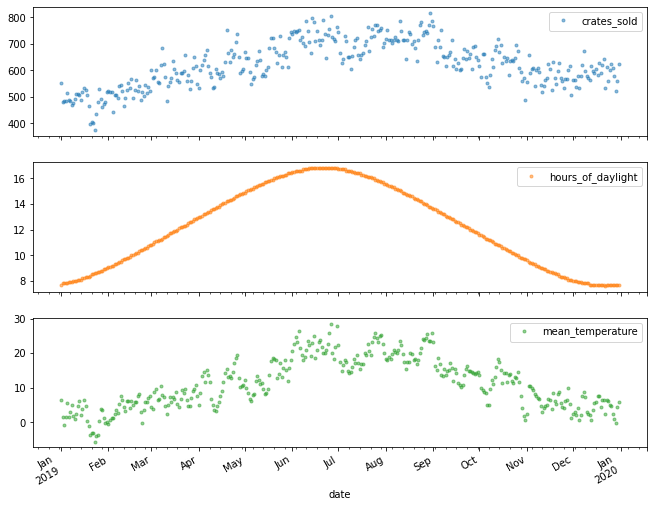

In [4]:
cols_plot = ['crates_sold', 'hours_of_daylight', 'mean_temperature']
axes = data_daily[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)

#### 1.1.2 Monthly data

I aggreate the data to monthly based. We can see the pattern of `crates_sold` can be roughly divided by season. For example, `crates_sold` has similiar pattern in summer (June, July, August). One thing might be interesting is December. `crates_sold` in December is higher compared to the previous month, which is not shown in `hours_of_daylight` and `mean_temperature`.

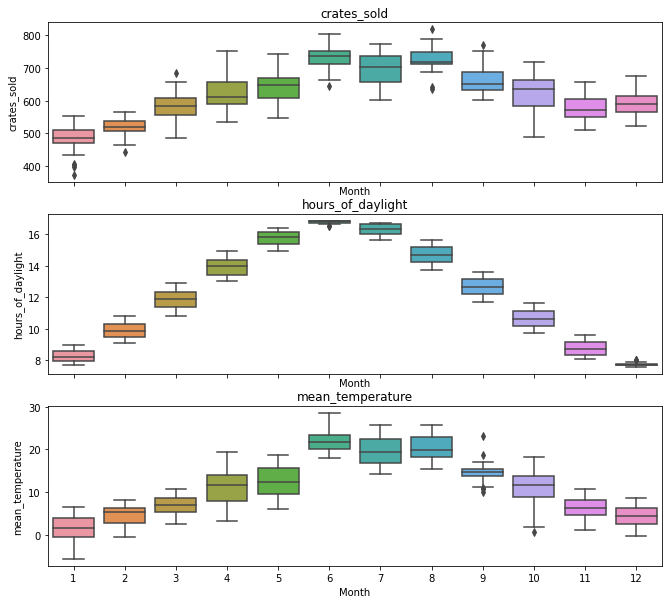

In [5]:
fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(cols_plot, axes):
    sns.boxplot(data=data_daily, x='Month', y=name, ax=ax)
    ax.set_title(name)

#### 1.1.3 Weekday 

We can see `crates_sold` is higher on Thursday, Friday and Saturday.

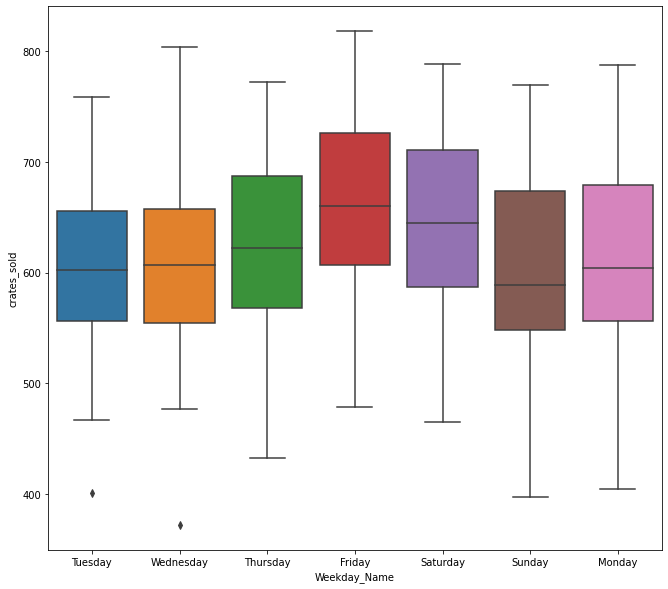

In [6]:
fig, axes = plt.subplots(1, 1, figsize=(11, 10), sharex=True)
sns.boxplot(data=data_daily, x='Weekday_Name', y='crates_sold');

#### 1.1.4 Day in the Month

There is no clear pattern for the difference of `crates_sold` in the day of the month 

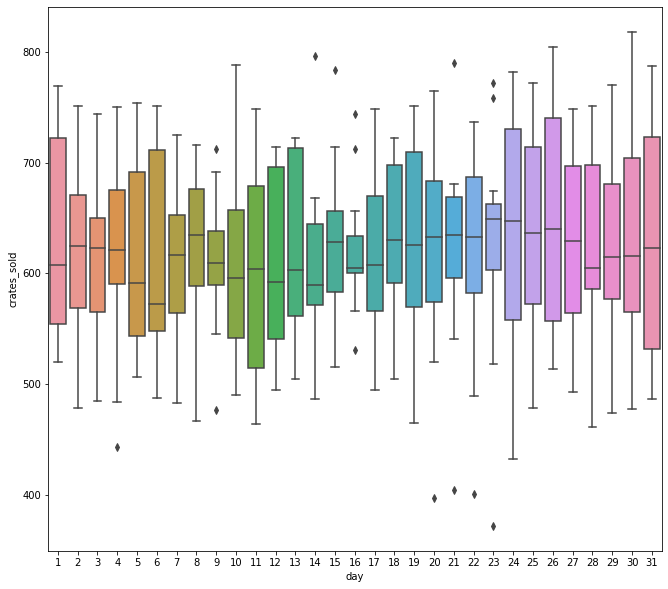

In [7]:
fig, axes = plt.subplots(1, 1, figsize=(11, 10), sharex=True)
sns.boxplot(data=data_daily, x='day', y='crates_sold');

### 1.2 Public Holiday

There are in total 10 holidys in 2019. 
Here we know this data is from **Berlin**, since Berlin is the only state in Germany which takes the International Women's Day as holiday.

In [8]:
data[data.public_holiday==1]

,date,crates_sold,hours_of_daylight,public_holiday,mean_temperature
0,2019-01-01,553,7.7,1,6.4
66,2019-03-08,683,11.3,1,7.9
108,2019-04-19,751,14.2,1,15.4
111,2019-04-22,678,14.3,1,12.8
120,2019-05-01,670,14.9,1,12.3
149,2019-05-30,721,16.4,1,15.6
160,2019-06-10,787,16.7,1,20.8
275,2019-10-03,661,11.5,1,9.3
358,2019-12-25,600,7.7,1,5.1
359,2019-12-26,625,7.7,1,4.6


We can see the `crates_sold` in public holiday is generally higher.   
Note: the sample sizes from two groups are quite different (355 vs 10)

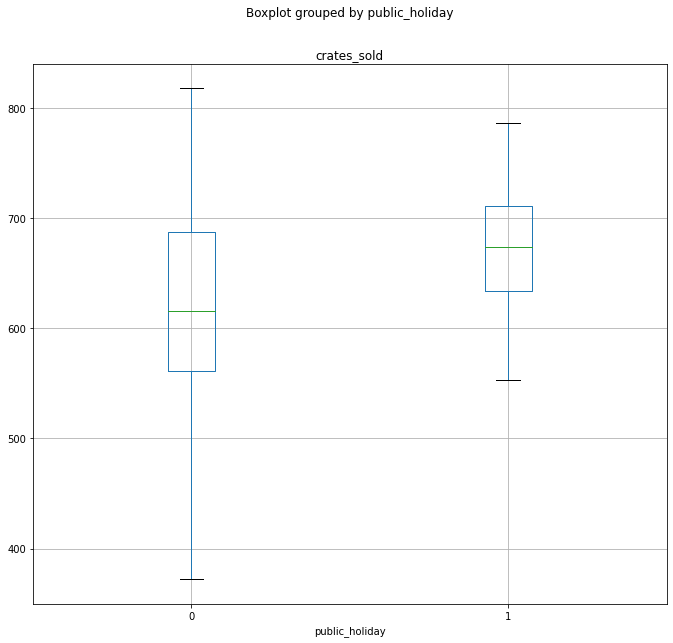

In [9]:
boxplot = data_daily.boxplot(column=['crates_sold'], by='public_holiday',figsize=(11, 10))

### 1.3 Correlation between dependent variables

I calculate the correlation and make the scatter plot of `hours_of_daylight` and `mean_temperature`. 
The correlation is very high (pearson correlation 0.801), which might cause the collinearity problem in the model.

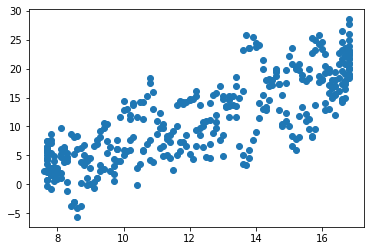

In [10]:
plt.scatter(data['hours_of_daylight'], data['mean_temperature'])
plt.show()

In [11]:
data[['hours_of_daylight','mean_temperature']].corr(method ='pearson') 

,hours_of_daylight,mean_temperature
hours_of_daylight,1.000000,0.801161
mean_temperature,0.801161,1.000000


# 2. Solution for Task 1

Further parts are presented:
- Linear Model
- Model diagonastic

## 2.1 Linear Model

Because the high correaltion between `hours_of_daylight` and `mean_temperature`, we only put `mean_temperature` in the model to avoid collinearity. I have tried to put the interaction in the model, but the interaction term was not significant. So I select the final model only with the main effect.

In [12]:
mod = smf.ols(formula='crates_sold ~ mean_temperature+public_holiday', data=data)
reg = mod.fit()
model_norm_residuals = reg.get_influence().resid_studentized_internal
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:            crates_sold   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     1067.
Date:                Tue, 10 Mar 2020   Prob (F-statistic):          1.64e-152
Time:                        23:47:55   Log-Likelihood:                -1790.2
No. Observations:                 365   AIC:                             3586.
Df Residuals:                     362   BIC:                             3598.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          498.9255      3.174  

## 2.2  Model Diagonastic

Assumption of the linear model:
the residual should be 
1. Normal distributed with mean equal to 0 
2. Equal variance
3. i.i.d

### 2.2.1 Normal distribution

I plot the histogram and the qqplot of the residual. The distribution looks like normal. I run the normalitiy test based on D’Agostino and Pearson’s test that combines skew and kurtosis to produce an omnibus test of normality. Based on the pvalue (0.234), we can not reject the null hypothesis that this data is from normal distribution 

mean=2.3e-13


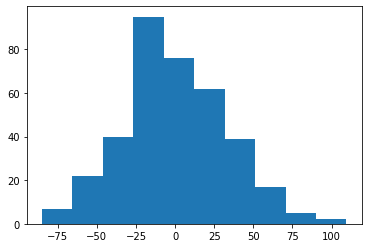

In [13]:
print(f"mean={mean(reg.resid):.1e}")
plt.hist(reg.resid)
plt.show()

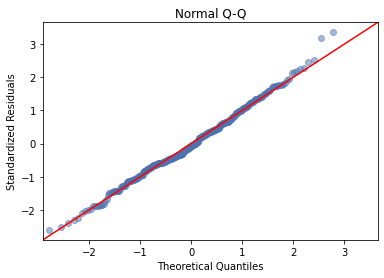

In [14]:
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');

In [15]:
k2, p = stats.normaltest(reg.resid)
print(f"p-value={p}")

p-value=0.23497419890989746


### 2.2.2 Residual Plot

The plot shows the predict value w.r.t the residuals.  The variance of the residuals seems constant. 

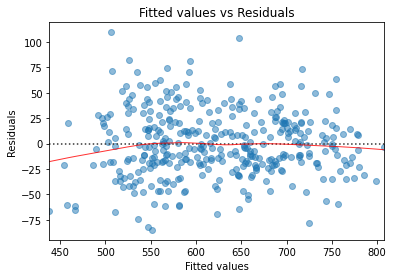

In [16]:
plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(reg.fittedvalues, data['crates_sold'],
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Fitted values vs Residuals')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

### 2.2.3 autocorrelation

The error should be independent of each other. 
But in the following plot, We can see a trend of **7**, which might indicate the error term is related to weekdays.

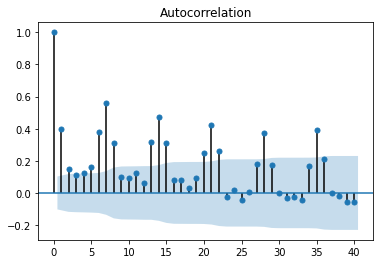

In [17]:
acf = smt.graphics.plot_acf(reg.resid, lags=40 , alpha=0.05)
acf.show()

# 3. Solution for Task 2

Comparing to task 1, I did feature engineering for combine and extract the information. 

## 3.1 feature engineering

I create few variables:
- Dummy variables for Weekday and Month
- `pre_holiday`: the day before holiday
- `mean_temperature_d1`: first order of differencing in `mean_temperature`
- `mean_temperature_d2`: second order of differencing in `mean_temperature`
- `mean_temperature_lag1`: lag1 in `mean_temperature`
- `mean_temperature_lag2`: lag2 in `mean_temperature`

In [18]:
new_data = pd.get_dummies(data_daily, columns=['Weekday_Name','Month'])
pre_holiday_index = (np.where(new_data.public_holiday==1)[0]-1)[1:]
new_data['pre_holiday'] = 0
new_data['pre_holiday'].iloc[pre_holiday_index ] = 1
new_data['mean_temperature_d1'] = np.append( np.array(new_data['mean_temperature'])[0:1],np.array(new_data['mean_temperature'][1:])-np.array(new_data['mean_temperature'][:-1]))
new_data['mean_temperature_d2'] = np.append( np.array(new_data['mean_temperature'])[0:2],np.array(new_data['mean_temperature'][2:])-np.array(new_data['mean_temperature'][:-2]))
new_data['mean_temperature_lag1'] = np.append( np.array(new_data['mean_temperature'])[0],np.array(new_data['mean_temperature'][:-1]))
new_data['mean_temperature_lag2'] = np.append( np.array(new_data['mean_temperature'])[0:2],np.array(new_data['mean_temperature'][:-2]))

## 3.2 Modeling
### 3.2.1 Model with weekday and month

From the following OLS Regression Results, we see the warning of singular matrix, which is due to the dummy variable. Therefore, I take out **Sunday, Monday, Tuesday and Wednesday**, since they have similiar coef and std. The same reason for month, **Jan and Feb** are removed because of nonsignificance. 

In [19]:
mod_week_month = smf.ols(formula='crates_sold ~ mean_temperature +public_holiday +Weekday_Name_Sunday+Weekday_Name_Monday+Weekday_Name_Tuesday+Weekday_Name_Wednesday+Weekday_Name_Friday + Weekday_Name_Saturday + Weekday_Name_Thursday  + Month_1+Month_2+Month_3 + Month_4 +Month_5 + Month_6 + Month_7 +Month_8 +Month_9 + Month_10 + Month_11 + Month_12', data=new_data) 
reg_week_month = mod_week_month.fit()
print(reg_week_month.summary())

                            OLS Regression Results                            
Dep. Variable:            crates_sold   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     311.8
Date:                Tue, 10 Mar 2020   Prob (F-statistic):          3.78e-204
Time:                        23:47:58   Log-Likelihood:                -1613.4
No. Observations:                 365   AIC:                             3267.
Df Residuals:                     345   BIC:                             3345.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                413

### 3.2.2 Model with pre-holiday, lag and difference

Since pre-holiday, lag and difference are not significant, I remove them from the model.

In [20]:
mod_p_d = smf.ols(formula='crates_sold ~ pre_holiday+mean_temperature_d1+mean_temperature_lag1+mean_temperature +public_holiday +Weekday_Name_Friday + Weekday_Name_Saturday + Weekday_Name_Thursday  + Month_3 + Month_4 +Month_5 + Month_6 + Month_7 +Month_8 +Month_9 + Month_10 + Month_11 + Month_12', data=new_data.iloc[1:]) 
reg_p_d = mod_p_d.fit()
print(reg_p_d.summary())

                            OLS Regression Results                            
Dep. Variable:            crates_sold   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     351.1
Date:                Tue, 10 Mar 2020   Prob (F-statistic):          2.12e-206
Time:                        23:47:58   Log-Likelihood:                -1608.3
No. Observations:                 364   AIC:                             3253.
Df Residuals:                     346   BIC:                             3323.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               457.22

### 3.2.3 Final Model I choose

In [21]:
mod_final = smf.ols(formula='crates_sold ~ mean_temperature +public_holiday +Weekday_Name_Friday + Weekday_Name_Saturday + Weekday_Name_Thursday  + Month_3 + Month_4 +Month_5 + Month_6 + Month_7 +Month_8 +Month_9 + Month_10 + Month_11 + Month_12', data=new_data) 
reg_final = mod_final.fit()

print(reg_final.summary())
                            

                            OLS Regression Results                            
Dep. Variable:            crates_sold   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     397.3
Date:                Tue, 10 Mar 2020   Prob (F-statistic):          6.95e-209
Time:                        23:47:58   Log-Likelihood:                -1614.4
No. Observations:                 365   AIC:                             3261.
Df Residuals:                     349   BIC:                             3323.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               456.83

## 3.3 Model Diagonastic

The same procedure as chapter 2

### 3.3.1 Normal Distribution

We can see the histogram and qqplot are very normal-like. P-value of the normality-test shows that we can not reject the null hypothesis of normality.

mean=1.4e-12


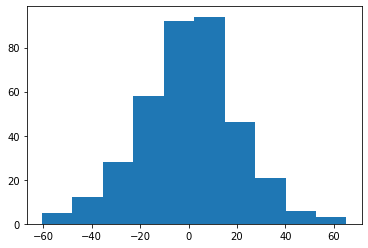

In [22]:
print(f"mean={mean(reg_final.resid):.1e}")
plt.hist(reg_final.resid)
plt.show()

p-value=0.21780867162216605


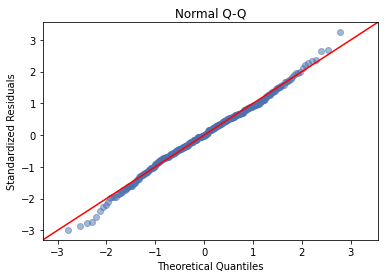

In [23]:
model_final_norm_residuals = reg_final.get_influence().resid_studentized_internal
QQ = ProbPlot(model_final_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');

k2, p = stats.normaltest(reg_final.resid)
print(f"p-value={p}")

### 3.3.2 Residual Plot

The plot shows the predict value w.r.t the residuals. The variance of the residuals seems constant. 

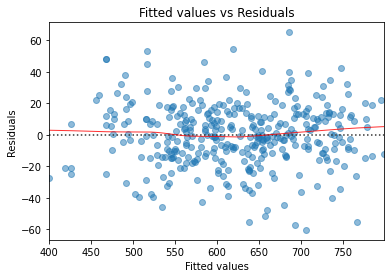

In [24]:
plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(reg_final.fittedvalues, data['crates_sold'],
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Fitted values vs Residuals')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

### 3.3.3 autocorrelation

Compared to the acf plot from last section, the trend of **7** disappears. Here we can not find obvious autocorrelation.

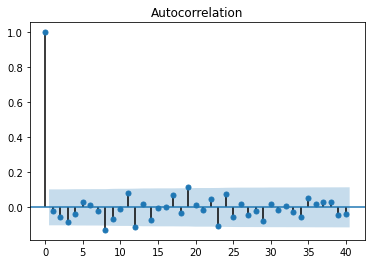

In [25]:
acf = smt.graphics.plot_acf(reg_final.resid, lags=40 , alpha=0.05)
acf.show()

### 3.3.4 Further check

I check the predict value vs true value,and there is no obvious outlier.
Furthermore, I check the date with high residual, and find that there is no obvious pattern.

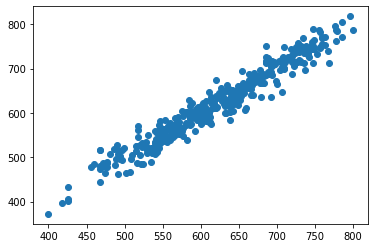

In [26]:
plt.scatter(reg_final.fittedvalues, data['crates_sold']);

In [27]:
new_data.iloc[np.where(reg_final.resid<-40)]

,crates_sold,hours_of_daylight,public_holiday,mean_temperature,day,Weekday_Name_Friday,Weekday_Name_Monday,Weekday_Name_Saturday,Weekday_Name_Sunday,Weekday_Name_Thursday,...,Month_8,Month_9,Month_10,Month_11,Month_12,pre_holiday,mean_temperature_d1,mean_temperature_d2,mean_temperature_lag1,mean_temperature_lag2
date,,,,,,,,,,,,,,,,,,,,,
2019-02-22,489,10.4,0,2.9,22,1,0,0,0,0,...,0,0,0,0,0,0,-5.3,-4.7,8.2,7.6
2019-05-25,612,16.2,0,13.0,25,0,0,1,0,0,...,0,0,0,0,0,0,-4.1,-1.0,17.1,14.0
2019-06-19,697,16.8,0,23.8,19,0,0,0,0,0,...,0,0,0,0,0,0,0.6,2.8,23.2,21.0
2019-06-23,646,16.8,0,20.8,23,0,0,0,1,0,...,0,0,0,0,0,0,0.8,0.7,20.0,20.1
2019-08-09,712,15.1,0,20.8,9,1,0,0,0,0,...,1,0,0,0,0,0,0.9,0.5,19.9,20.3
2019-08-21,635,14.4,0,16.9,21,0,0,0,0,0,...,1,0,0,0,0,0,-1.3,-1.2,18.2,18.1
2019-09-26,606,12.0,0,14.6,26,0,0,0,0,1,...,0,1,0,0,0,0,-0.2,-0.2,14.8,14.8
2019-10-18,635,10.5,0,14.3,18,1,0,0,0,0,...,0,0,1,0,0,0,0.1,3.0,14.2,11.3
2019-10-20,583,10.3,0,13.7,20,0,0,0,1,0,...,0,0,1,0,0,0,2.1,-0.6,11.6,14.3


# 4. Conclusion and Remarks

The final model fits the data quite good and the residuals fit the model assumption.
   
Concern:   
The R-square of the model is 0.94. This is extreme high, even a bit unusal. This might be due to overfitting. For solving this potential problem, I will use more historical data to verifiy this model.

Remarks:

1. Make the sales strategy:  
Based on the data, the sale situation in certain weekdays and months is lower. We can suggest the marketing team to provide special deals in those day to enhance the orders.

2. Make the plan for resource arrangemnet:  
The sales situation depends highly on the season. We can adjust the arrangemnet for drivers/vehicles for delivering.
This arrangemnet can also applied to the drink storage.

3. Difference between cities:  
This data is from Berlin. When new markets are opened in other cities, this model can be used as baseline, and we can change the model structure according to the real data.